## Wavelets, Filters and Data QC  

This notebook loads a VSP data set into 2 numpy arrays   
It gives examples of editing, plotting and filtering the VSP  
Common instantaneous attributes are calculated and displayed
It also give examples of 3 common seismic wavelets

In [1]:
# important geophysical imports
# I use several methods to load packages as examples

from iovsp.segyin import readsegyio3
from iovsp.segyout import write_segyio

from plotvsp.seisplots import wiggle_plot, four_plots, plotcolor
from procvsp.geometry import importascii, geovel

# Best method is the one below, you always know where functions are 
# coming from
import procvsp.spec as specvsp
import procvsp.spec2d as spec2d

import procvsp.sigproc as sgp
import procvsp.utils as utilvsp
import procvsp.wavelets as wav

## Load the VSP SEG-Y file  
 
 - uses segyio data loading package
 - source and receiver locations are assumed to be in SEG-Y trace headers
 - user needs to supply basic geometry parameters
      - seismic replacement velocity
      - surface seismic datum elevation
      - drill floor elevation
      - source elevation  

The sample rate read from the file needs to be QC'ed!!!

In [2]:
    #################### get the ZVSP SEGY filename ############################
    
#    filename = ('C:\\Users\\acampbell45\\Documents\\Python_Scripts'
#        '\\Synthetic_data\\data\\zvsp_z_fd_mod6_12p5ft_grid_delayed.sgy')
#    filename = ('C:\\Users\\acampbell45\\Documents\\Python_Scripts'
#        '\\VSP-processing\\data\\Tillard_ZVSP_raw_z_stacked.sgy')

    filename = ('data\\zvsp_z_fd_mod6_12p5ft_grid_delayed.sgy')
    
    ################### input desired geometry parameters ######################
    
    RepVel= 5000     # replacement velocity
    SRD_ASL = 0    # SRD elevation above sea level
    DF_ASL = 0    # drill floor elevation ASL
    SrcElev = -10   # source elevation ASL

    ###################### run basic segy loading functions #################### 
    
    file_head = 'n'         # print binary and text header to screen    
    pr_thead = 'n'          # print a table of trace headers
   
    data, numsamp, samprate, fs, theader =  readsegyio3(filename, file_head, 
                                            DF_ASL, SrcElev, SRD_ASL, pr_thead)


̲D̲a̲t̲a̲ ̲L̲o̲a̲d̲i̲n̲g̲ ̲w̲i̲t̲h̲ ̲s̲e̲g̲y̲i̲o̲ ̲S̲t̲a̲t̲s̲ ̲:

 data shape : (320, 3050)  delta t : 1000.0
 data type : float32
 trace header file shape : (320, 15)
 samples : 3050  traces : 320  fs samprate hz :  1000.0 samprate microseconds :  1000 
 numsamp from headers :  3050
 first time header value :  [10.9] 
 first auxilliary time header value : [0]
 source depth from header trace 1 : [10.]


## Velocity Calculations  
 - Calculate interval velocities. Shallowest velocity is calculated separately and tacked on to velocity array  
 - Generate a version which is rounded and truncated for display as text

In [9]:
    ############ geometry corrections and velocity calculations ################
    
    table = 'n'     # print a time-depth-velocity listing to screen y or n    
    vel_headers = geovel( theader, RepVel, table)


̲G̲e̲o̲v̲e̲l̲ ̲S̲t̲a̲t̲s̲ ̲:
 Theader shape (320, 15) Vheader shape: (320, 17)
 TVD_SRD shape : (320,)  IntVel shape : (320,)
 TVDSrc 2 vals   [ 90. 140.] 
 TVDSRD 2 vals  [100. 150.] 
 TTVert 2 vals   [10.902 17.332]


## Chose the desired trace range to process

In [10]:
    ###################### trim arrays by receiver  ############################
    
    first_rcv =1
    last_rcv = 200   
    data_edit, theader_edit = utilvsp.depthlimit(data,vel_headers, first_rcv, last_rcv)
  


̲D̲e̲p̲t̲h̲l̲i̲m̲i̲t̲ ̲S̲t̲a̲t̲s̲ ̲:
 data shape :  (320, 3050)  data dtype :  float32
 headers shape : (320, 17)
 first : 0  last :  199
 headers new shape : (199, 17)
 data new shape :  (199, 3050)


## Trace normalize data file  
 Remove transmission effects and uncorrected gain effects  
 on downgoing by normalizing the downgoing amplitudes  
 - normalize by row (receiver) using Frobenius normalization. Can be changed to other norms.  
 - Be careful with axis number, determines trace normalization or time normalization


 row_sums shape (199,)


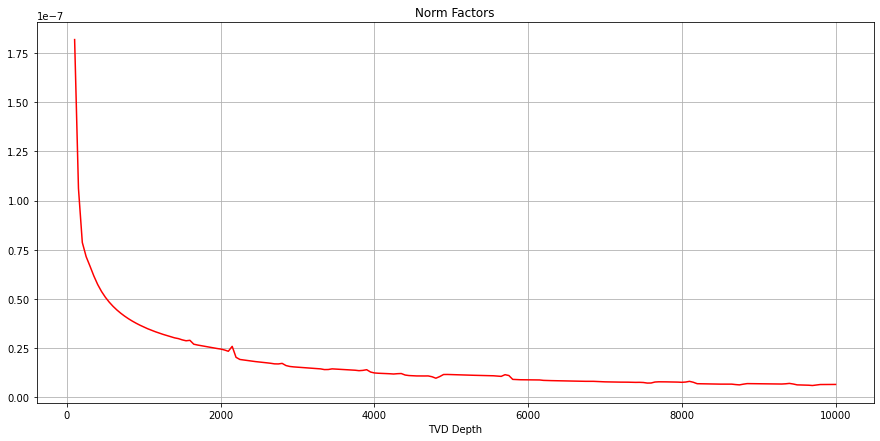

In [5]:
    ############  apply trace normalization if requested #######################  
    
    Data_norm = 'y'         # normalize data, n for gather norm, y for trace nrm
    DScalar = 1             # usually 1, may be removed in future    
    normed_edit = sgp.normalize(data_edit, Data_norm, theader_edit, DScalar)

## Example of Applying a Band-Pass( Butterworth) Filter  
 - Make 2 simple QC plots of frequency and impulse response
 - Plot the filtered VSP

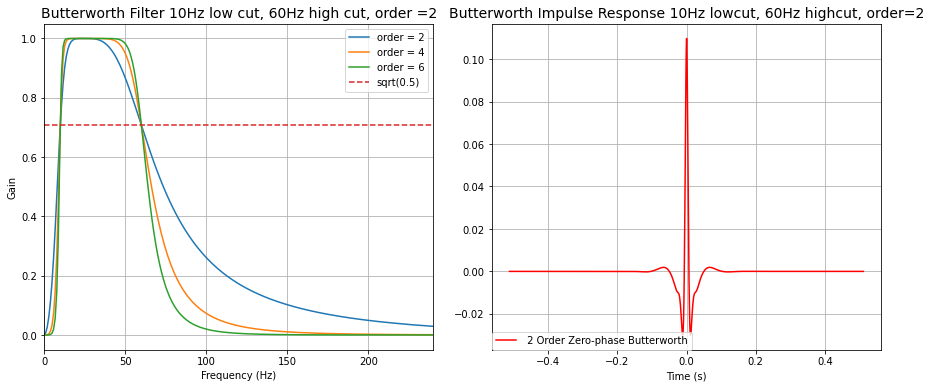

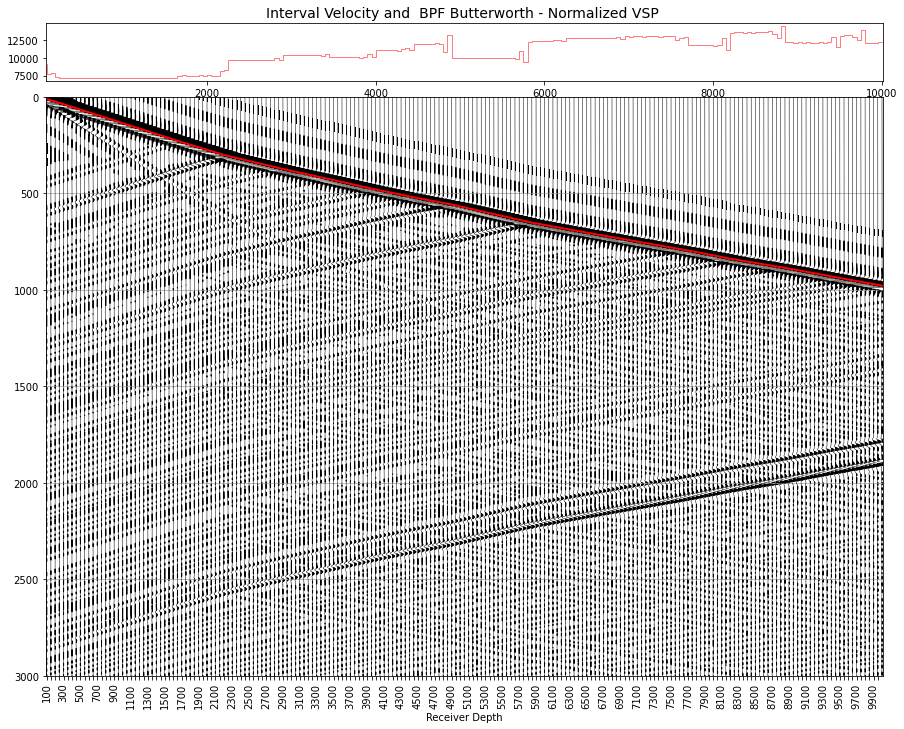

In [6]:
    ################### Butterworth filter testing #############################
    
    # Sample rate and desired cutoff frequencies (in Hz).

    lowcut = 10
    highcut = 60
    qcplot = 'y'
    order  = 2     # order gets doubled by implementation of filter, be careful    
    numfsamp = 1024   # for wavelet QC plot, must be even      
    buttfilt = specvsp.bandpass_filter(normed_edit, lowcut, highcut, fs, order, 
                                      numfsamp, qcplot)
    # make a wiggle plot of traces
    plot_params = {"pol":'n', 
                    "Tmax":3000, "Tmin":0, 
                    "first_rcv":first_rcv, 
                    "spacing":'z', 
                    "skiplabel":4, 
                    "fs":fs, 
                    "norm":'n',
                    "scal":1000, 
                    "title_top":' BPF Butterworth - Normalized VSP ',
                  "info_wig":'n',
                   "timframe":'owt'}
    wiggle_plot(theader_edit,buttfilt, **plot_params)

## A simple Bandpass Filter  
  Convolve data with a custom windowed sync filter  
  An alternative to Buttworth filter


̲S̲i̲m̲p̲l̲e̲ ̲B̲P̲F̲ ̲I̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲ ̲:


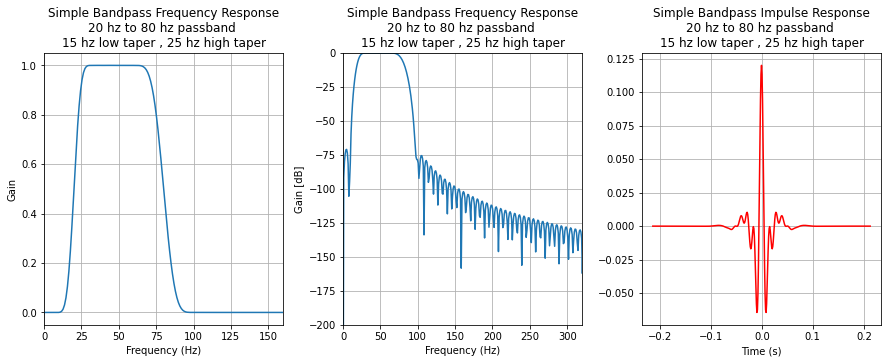

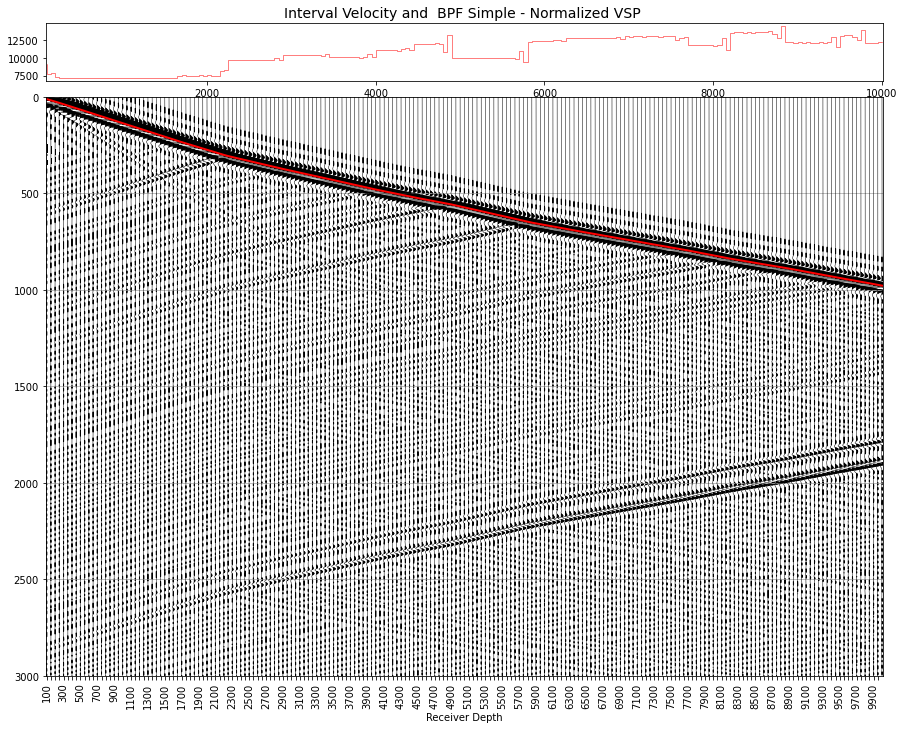

In [7]:
    ######################## Simple BPF testing ################################

    lowcut = 20
    highcut = 80
    rolloff_low = 15
    rolloff_high = 25
    
    simpfilt=specvsp.simple_bpf(normed_edit, lowcut, highcut, rolloff_low,rolloff_high, fs)
    # make a wiggle plot of traces
    plot_params = {"pol":'n', 
                    "Tmax":3000, "Tmin":0, 
                    "first_rcv":first_rcv, 
                    "spacing":'z', 
                    "skiplabel":4, 
                    "fs":fs, 
                    "norm":'n',
                    "scal":1000, 
                    "title_top":' BPF Simple - Normalized VSP ',
                  "info_wig":'n',
                  "timframe":'owt'}
    wiggle_plot(theader_edit,simpfilt, **plot_params)

# Frequency Analysis  - 1D  
A windowed spectrum for one trace  
Amplitude and Power are plotted


̲F̲r̲A̲n̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
fs : 1000.0


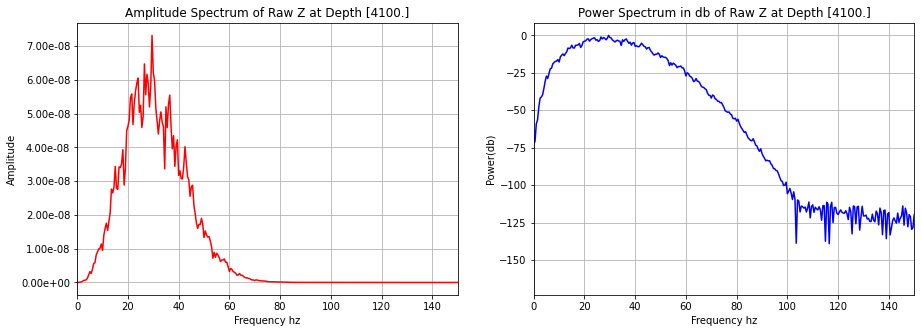

 buttfilt type : float32

̲F̲r̲A̲n̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
fs : 1000.0


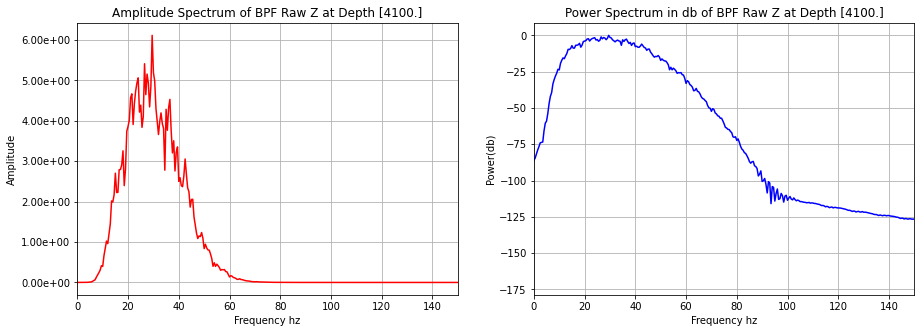

In [9]:
    ########################  FRequency ANalysis    ############################
    
    trace = 80
    time_win = 'y' # window trace prior to fft
    time_range = [0, 2000]
    freq_range = [0, 150]    
    title_fran = 'Raw Z'    
    specvsp.spec_1d(data_edit, time_range, freq_range, theader_edit, trace, fs, 
         time_win, title_fran)
    
    title_fran = 'BPF Raw Z'
    print( ' buttfilt type :',buttfilt.dtype)    
    specvsp.spec_1d(buttfilt, time_range, freq_range, theader_edit, trace, fs, 
         time_win, title_fran)


# Frequency Analysis  - Frequency/Depth  
An image plot of frequency spectra for every receiver   
Amplitude and Power are plotted


̲F̲r̲A̲n̲ ̲i̲m̲a̲g̲e̲2̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
 data shape : (198, 3050)  TTobs shape : (199,)
 trindex.min(): 1.0  trindex.max(): 199.0
fs : 1000.0
 final idata_win shape : (198, 3072)  idata shape : (198, 3050)  N : 3072
 keep : [ True  True  True ... False False False]  keep.size : 3072  freq shape : (1536,)


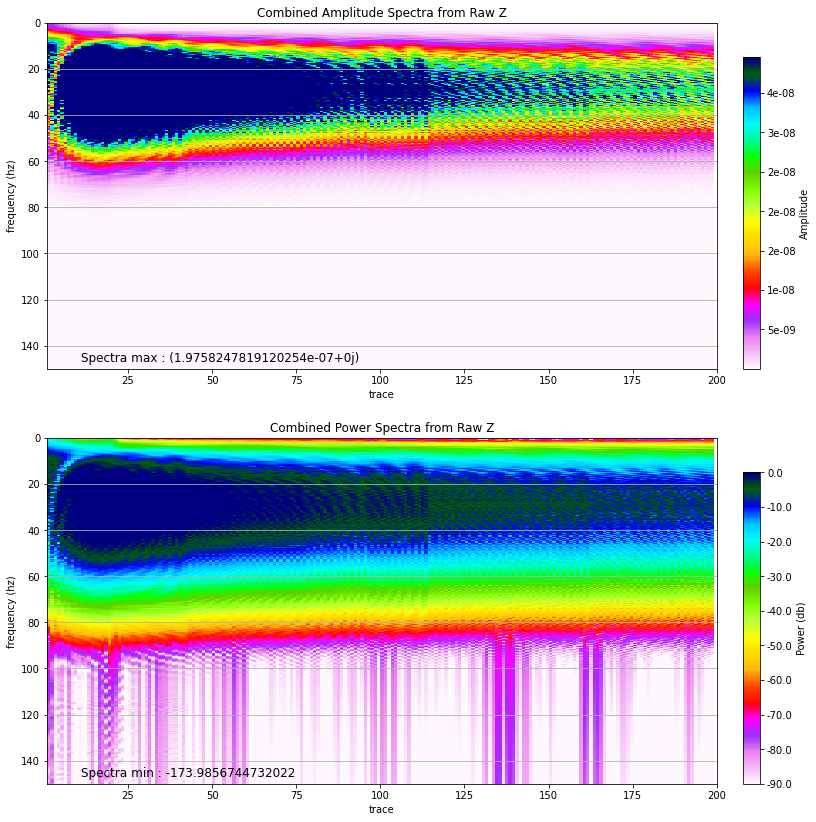

In [10]:
    # 2D spectra - a spectrum per trace
    spacing = 'z' # Z for traces spread by receiver depth    
    scale = 5 # scale up image apmlitude plot
    title_fran = 'Raw Z'
    time_win = 'y' # window trace prior to fft
    time_range = [0, 3050]
    freq_range = [0, 150]    
    trace_range = [1, 200]
    db_range = [-90,0]
    specvsp.spec_FZ(data_edit, time_range, theader_edit, fs, spacing, 
         db_range, freq_range, trace_range, scale, title_fran, time_win)

## F/K Spectrum

Utilizes 2D FFT
Constant receiver spacing is assumed


̲n̲e̲x̲t̲p̲o̲w̲2̲ ̲i̲n̲f̲o̲ ̲a̲n̲d̲ ̲p̲a̲r̲a̲m̲e̲t̲e̲r̲s
 x : 3050
 nextpow2 : 12.0

̲f̲k̲t̲r̲a̲n̲_̲n̲u̲m̲p̲y̲ ̲i̲n̲f̲o̲ ̲a̲n̲d̲ ̲p̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲b̲e̲f̲o̲r̲e̲ ̲f̲f̲t
 seis.T shape : (3050, 199) 
 numsamp : 3050 
 ntrace : 199
 rcvz shape : (199,) 
 t shape : (3050,) 
 dx : 50.0 
 dt : 0.001
 nf : 4096 
 nk : 4096
 fk shape : (4096, 4096)
 freq min -500.0  freq max 499.755859375
 k min -0.01  k max 0.0099951171875
 fk_for_plot shape : (4096, 2047)

̲f̲k̲ ̲p̲l̲o̲t̲ ̲i̲n̲f̲o̲ ̲a̲n̲d̲ ̲p̲a̲r̲a̲m̲e̲t̲e̲r̲s
fk shape : (2047, 4096)
 df : 0.244140625 
 stop freq index : 327 
 f shape : (4096,) 
 dk : 4.882812500000763e-06 
 startk : 511 
 stopk : 3582
 kvel, fvel: [0, -0.08329264322916667] [0, 499.755859375]  slope : -6000.0
 xy label location: (-0.00375, 22.5)


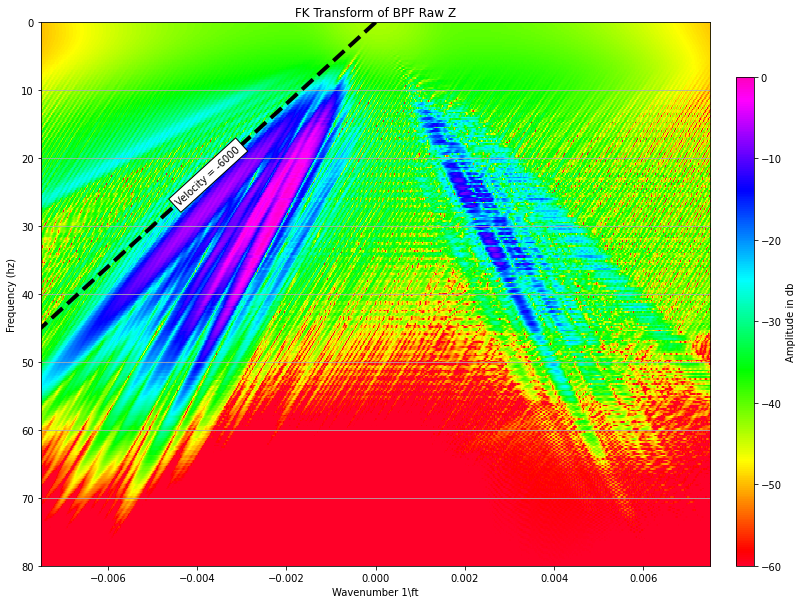

In [11]:
    ############################ FK analysis ####################################
    
    ishift = 1                                      # display positive freqs.
    title_fk='FK Transform of BPF Raw Z'
    line_velocity=-6000    
    fktrans, freqnp_unwrap, knp_unwrap, numsamp, ntrace \
    = spec2d.fktran_numpy(buttfilt, theader_edit, fs, ishift, title_fk, line_velocity)
                

## Instantaneous Attributes  
The program uses the Hilbert transform to calculate the analytic traces.

It is hardwired to write out:
1. Instantaneous Phase (wrapped)  
2. Instantaneous Frequency  
3. Amplitude Envelope

Plotting is a separate routine, plots attributes as color images  



̲A̲t̲t̲r̲i̲b̲u̲t̲e̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
 fs : 1000.0 
  max trace amplitude :  5.060345e-08 
  max amplitude envelope :  5.3998524297812556e-08 
  max inst frequency :  499.9999316628345 
  max inst phase :  179.99818711949567
 inst freq shape : (199, 3049)
 inst amp shape : (199, 3050)
 freq_mid shape:  (3050,)  amp_mid shape:  (3050,)
VSPdata shape: (199, 3050) tindex shape : (199, 3050) rindex shape : (199, 3050)


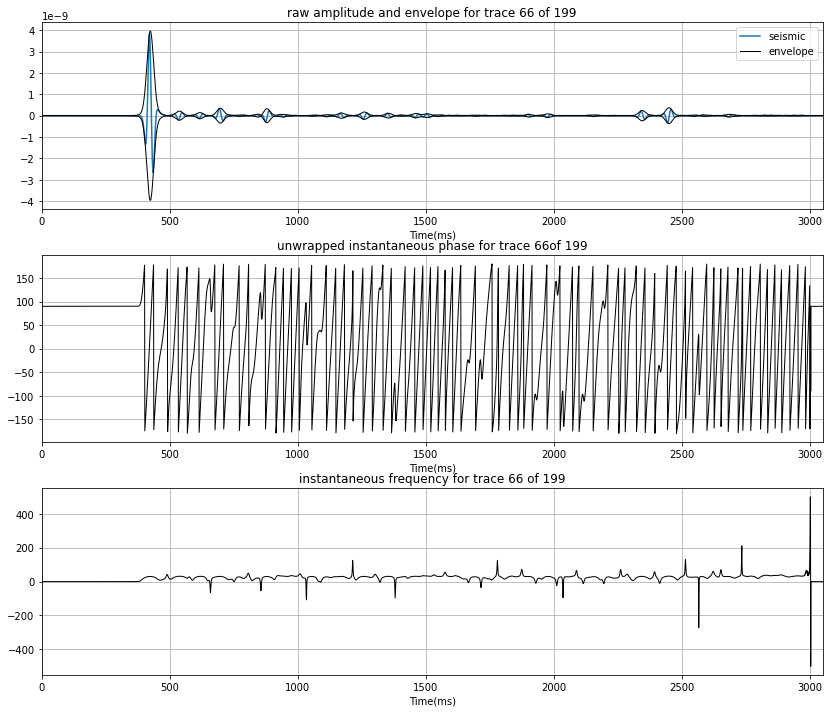

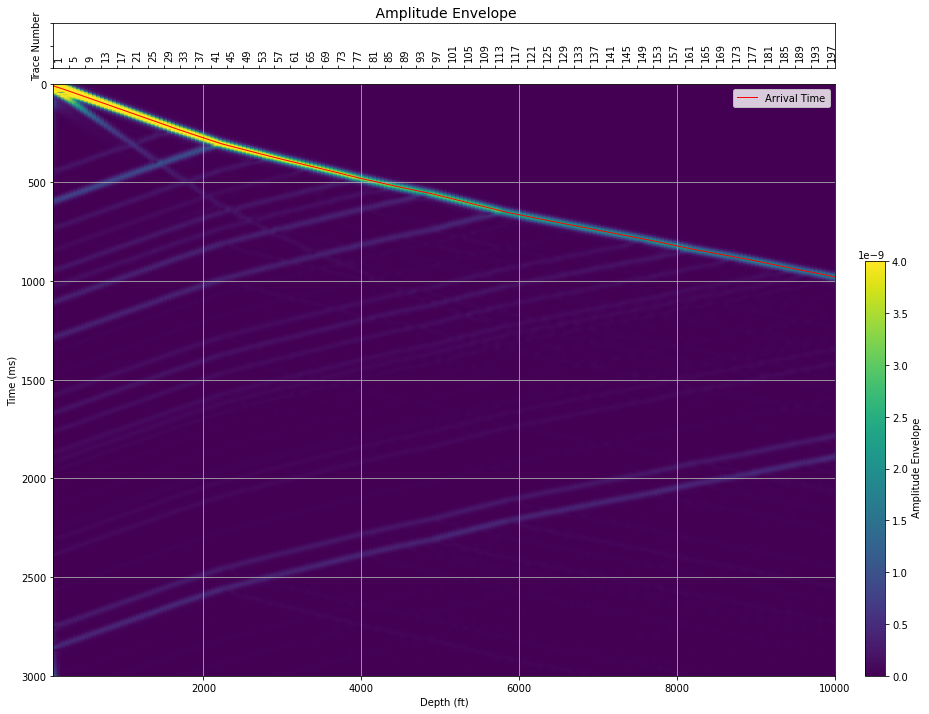

VSPdata shape: (199, 3050) tindex shape : (199, 3050) rindex shape : (199, 3050)


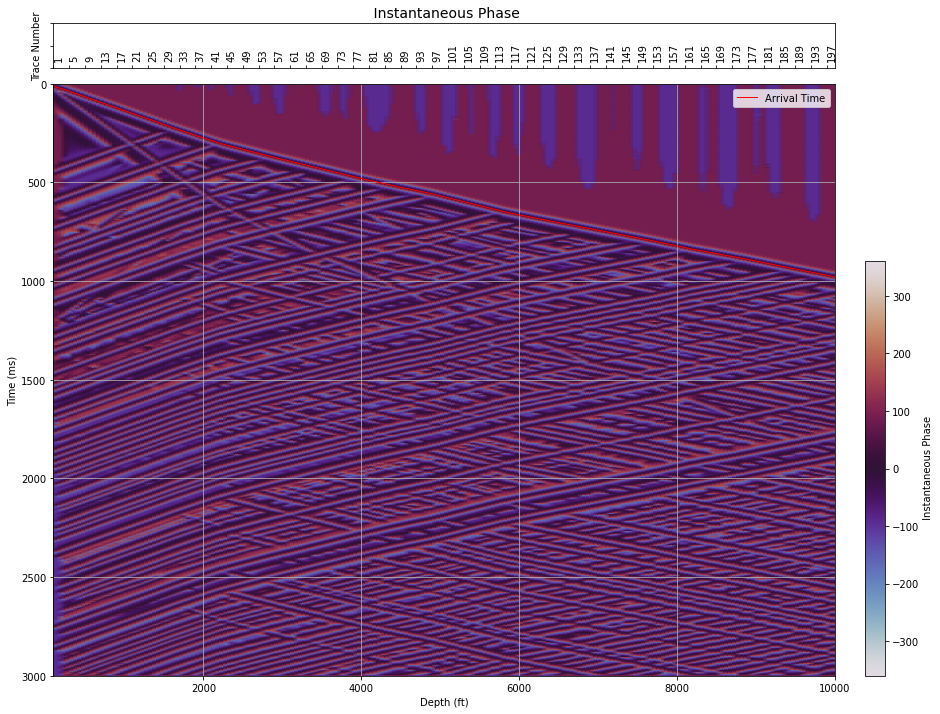

In [12]:
    ################# calculate instantaneous attributes ###################
    
    data_env, data_ifreq, data_iphase = sgp.attributes(data_edit,fs)
     
    colorplot_params = {"pol":'n', 
                    "Tmax":3000, "Tmin":0, 
                    "show_time":'y', # show arrival time curve
                    "first_rcv":first_rcv, 
                    "spacing":'z', 
                    "skiplabel":4,
                    "samp_decimate":1,
                    "fs":fs, 
                    "norm":'n',
                    "min_amp":0, "max_amp":.4e-8,
                    "title_top":' Amplitude Envelope',
                    "color": 'viridis',
                    "png":'n'}
    plotcolor(theader_edit, data_env, **colorplot_params)
    
    colorplot_params = {"pol":'n', 
                    "Tmax":3000, "Tmin":0,
                    "show_time":'y', # show arrival time curve
                    "first_rcv":first_rcv, 
                    "spacing":'z', 
                    "skiplabel":4,
                    "samp_decimate":1,
                    "fs":fs, 
                    "norm":'n',
                    "min_amp":-360, "max_amp":360,
                    "title_top":' Instantaneous Phase',
                    "color": 'twilight',
                    "png":'n'}
    plotcolor(theader_edit, data_iphase, **colorplot_params)        

## Play with some wavelets  
Ricker, Ormsby and Butterworth are implemented

In [ ]:
    ######################## Ormsby Wavelet   ##################################
    timlength=1.024
    sampint = .002
    flimits = [6,18,45,65]
    ormwave = wav.ormsby(timlength, sampint, flimits)
    
    ######################## Ricker Wavelet   ##################################
    timlength=1.024
    sampint = .002
    flimits = 30
    rickwave = wav.ricker(timlength, sampint, flimits)
    
    ###################### Butterworth Wavelet   ###############################
    lowcut = 18
    highcut = 45
    order  = 3   # order gets doubled by implementation of filter, be careful    
    numfsamp = 1024   # for wavelet QC plot, must be even     
    wav.butterworth(lowcut, highcut, fs, numfsamp, order)